# Lista 6 - K-médias e PCA

<span style="position: absolute; top: 10px; right: 10px; background: green; padding: 0.5em; color: white; border-radius: 8px; font-weight: bold">Vaux Gomes</span>

### Importações

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import time
import warnings
warnings.filterwarnings('ignore')

### Loading

In [70]:
penguins = np.genfromtxt('penguins.csv', delimiter=',')
quake = np.genfromtxt('quake.csv', delimiter=',')

print(f'Penguins: {penguins.shape}')
print(f'Quake: {quake.shape}')

Penguins: (333, 5)
Quake: (2178, 2)


In [73]:
# Preprocessing: Scaling and centering
quake = preprocessing.scale(quake)

# 
penguins_labels = penguins[:, -1]
penguins = preprocessing.scale(penguins[:, :-1])


### Distance Functions

In [8]:
def euclidian_distance(u, v):
  return np.linalg.norm(u - v, axis=1)

def mahalanobis_distance(u, v):
  e = u - v
  
  X = np.vstack([u, v])
  V = np.cov(X.T) 
  p = np.linalg.inv(V)

  return np.sqrt(np.sum(np.dot(e,p) * e, axis = 1))

### K-Means

#### Davies-Bouldin
            
The index is defined as the average similarity between each cluster $C_i$ for $i = 1,...,k$ and its most similar one $C_j$

* $s_i$ the average distance between each point of cluster $i$ and the centroid of that cluster -- also known as **cluster diameter**
* $d_{ij}$ the distance between cluster centroids $i$ and $j$

A simple choice to construct $R_{ij}$ so that it is nonnegative and symmetric is:

$$
\displaystyle R_{ij} = \frac{s_i + s_j}{d_{ij}}
$$

Then the Davies-Bouldin index is defined as:

$$
\displaystyle DB = \frac{1}{k} \sum_{i = 1}^k \max_{i \ne j} R_{ij}
$$

Reference: https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index

In [9]:
class KMeans:
  ''' K-Means: This implementation uses Davies-Bouldin metric to choose the best cluster set '''

  #
  def __init__(self, k, repetitions=0, 
                distance=euclidian_distance):
    self.k = k
    self.repetitions = max(1, repetitions)
    self.distance = distance

  # 
  def fit(self, X):
    #
    indexes = list(range(X.shape[0]))
    
    #
    self.C = None
    self.labels = None
    self.db = None # david-bouldin
    
    # Main loop
    for i in range(self.repetitions):
      # print(f'Repetition {i+1}')
      
      # Randomly choose k instances for cluster centers
      C = X[np.random.choice(indexes, size=self.k)]
      
      #
      labels = None
      exit = False

      # Loop until clusters do not move
      while not exit:
        # Distance from each one of the current clusters to each of the points
        distances = None

        for c in C:
          if distances is None:
            distances = self.distance(c, X).reshape(1, X.shape[0])
          else:
            distances = np.append(distances, self.distance(c, X)
                        .reshape(1, X.shape[0]), axis=0)

        # Indexes for each instances of each cluster
        labels_ = np.argmin(distances, axis=0)
        
        # Calculate new centroid as the mean point
        C_ = np.array(C, copy=True)
        
        for label in range(self.k):
          c_points = X[labels_ == label]

          if c_points.shape[0] > 0:
            C_[label] = X[labels_ == label].mean(axis=0)
        
        # Stops if nothing moves
        if np.sum(C - C_) == 0:
          exit = True
        else: # Updates if it moves
          C = np.array(C_, copy=True)
          labels = np.array(labels_, copy=True)
                          
      # Calculate Davies-Bouldin:
      db = self.david_bouldin__(X, C, labels)

      # Choose best repetition based on Davies Bouldin metric
      if self.C is None or self.db > db:
        self.C = C
        self.labels = labels
        self.db = db

  #
  def david_bouldin__(self, X, C, labels):
      #
      acc = 0
      
      # Cluster diameter
      S = []
      for label, c in enumerate(C):
        S.append(euclidian_distance(c, X[labels == label]).sum())

      for i in range(C.shape[0]):
        distances = euclidian_distance(C, C[i]) # Inter centroids
        
        # Max Rij
        R = []          
        for j in range(C.shape[0]):
          if i == j: continue
          R.append((S[i] + S[j])/distances[j])

        acc += max(R)

      return acc / self.k

## Questão 1

Considere o conjunto de dados disponível em `quake.csv`, organizado em 2 colunas de atributos. Os dados referem-se a latitudes e longitudes de locais em que foram registrados terremotos.

<div class="alert alert-block alert-warning">
    <b>Atenção:</b> Minha implementação usa DB para encontrar o melhor conjunto de clusters de tamanho k dentre as n repetições.
</div>

#### K-médias com distância Euclidiana


In [18]:
# So it can be repeatable
np.random.seed(42)
#
models_e = {}

#
start = time.time()

for k in range(4, 21):
  mdl = KMeans(k, repetitions=20)
  mdl.fit(quake)
  
  models_e[k] = mdl

end = time.time()    

#
print(f'Fitting time: {end - start:.3f}ms') 


Fitting time: 9.695ms


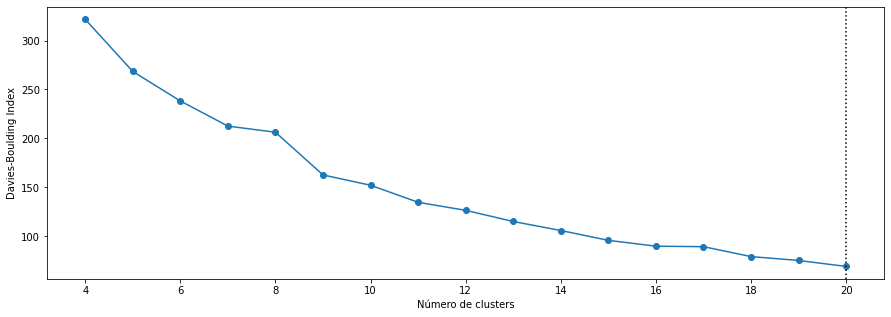

In [19]:
dbs = dict(map(lambda c: (c.k, c.db), models_e.values()))
best_e_idx = np.argmin(list(dbs.values())) + 4

#
plt.figure(figsize=(15, 5))
plt.plot(dbs.keys(), dbs.values(), marker='o')
plt.axvline(x = best_e_idx, color = 'k', linestyle=':') # Best DB
plt.xlabel("Número de clusters")
_ = plt.ylabel("Davies-Boulding Index")

##### Melhor k

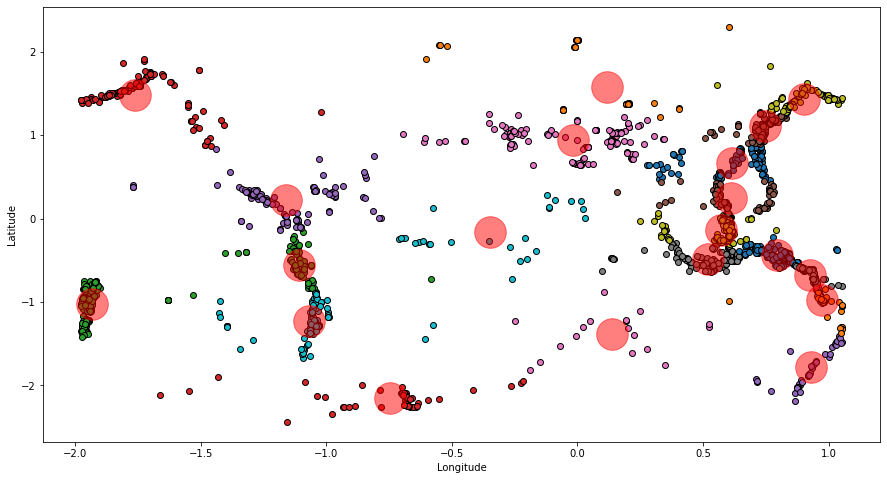

In [12]:
best = models_e[best_e_idx]

plt.figure(figsize=(15, 8))
# plt.axis('off')

for l in range(best.k):
  filtered_label = quake[best.labels == l]
  plt.scatter(filtered_label[:, 1], filtered_label[:, 0], edgecolors='k')

plt.scatter(best.C[:, 1], best.C[:, 0], s=1000, color='red', alpha=0.5)

plt.xlabel("Longitude")
_ = plt.ylabel("Latitude")

In [13]:
# Plot de todos os modelos
def plot_all(models):
    fig, axs = plt.subplots(3, 6, figsize=(15, 10))
    k = 4

    for i in range(3):
        for j in range(6):
            #
            ax = axs[i][j]
            ax.axis('off')

            if k not in models.keys():
                continue

            #
            mdl = models[k]
            np.random.seed(42)

            for l in range(k):
                # color = [np.round(np.random.rand(),1), np.round(np.random.rand(),1), np.round(np.random.rand(),1), 0.8]

                filtered_label = quake[mdl.labels == l]
                ax.scatter(filtered_label[:, 1], filtered_label[:, 0], 
                           # color=color, 
                           edgecolors='k')
            
            ax.title.set_text(f'K = {k}')
            

            #
            k += 1

# Acabei não usando essa função, mas funciona
# plot_all(models)

#### K-médias com distância Mahalanobis

> Com esta métrica eu obtinha um erro em alguns casos no cálculo do DB index. De modo que usei a distância euclidiana apenas no cálculo do DB index.

In [14]:
# So it can be repeatable
np.random.seed(42)
#
models_m = {}

#
start = time.time()

for k in range(4, 21):
  mdl = KMeans(k, repetitions=20, distance=mahalanobis_distance)
  mdl.fit(quake)
  
  models_m[k] = mdl
end = time.time()    

#
print(f'Fitting time: {end - start:.3f}ms') 

Fitting time: 24.881ms


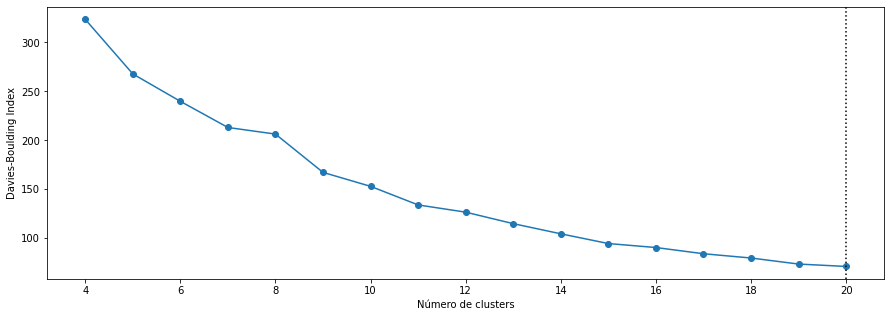

In [15]:
dbs = dict(map(lambda c: (c.k, c.db), models_m.values()))
best_m_idx = np.argmin(list(dbs.values())) + 4

#
plt.figure(figsize=(15, 5))
plt.plot(dbs.keys(), dbs.values(), marker='o')
plt.axvline(x = best_m_idx, color = 'k', linestyle=':') # Best DB
plt.xlabel("Número de clusters")
_ = plt.ylabel("Davies-Boulding Index")

##### Melhor k

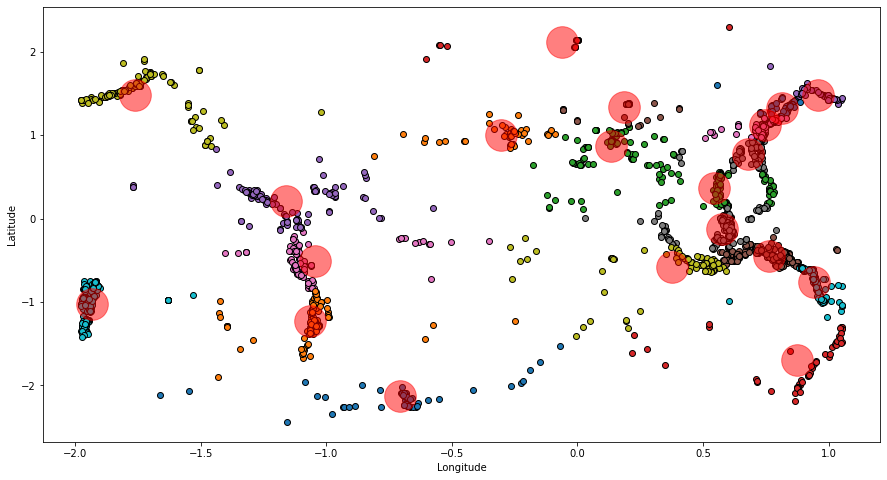

In [16]:
best_m = models_m[best_m_idx]

plt.figure(figsize=(15, 8))
# plt.axis('off')

for l in range(best_m.k):
  filtered_label = quake[best_m.labels == l]
  plt.scatter(filtered_label[:, 1], filtered_label[:, 0], edgecolors='k')

plt.scatter(best_m.C[:, 1], best_m.C[:, 0], s=1000, color='red', alpha=0.5)

plt.xlabel("Longitude")
_ = plt.ylabel("Latitude")

## Questão 2
Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão.

In [88]:
def PCA2(X):
  # Computing covariance matrix
  cov_mat = np.cov(X, rowvar=False)

  # Computing Eigenvectors and Eigenvalues
  eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
  # print(eigen_values)

  # Sorting
  sorted_idx = np.argsort(eigen_values)[::-1]
  # print(sorted_idx)

  # Similarity
  sorted_evector = eigen_vectors[:, sorted_idx]
  # print(sorted_evector)

  for i, v in enumerate(eigen_values[sorted_idx]):
    print(f'Feature {i+1}: {100*v/sum(eigen_values):.2f} %')

  n_components = 2
  eigen_components = sorted_evector[:, 0:n_components]

  # Transformation
  return np.matmul(X, eigen_components)

points = PCA2(penguins)

print(points.shape, penguins.shape)

Feature 1: 68.63 %
Feature 2: 19.45 %
Feature 3: 9.22 %
Feature 4: 2.70 %
(333, 2) (333, 4)


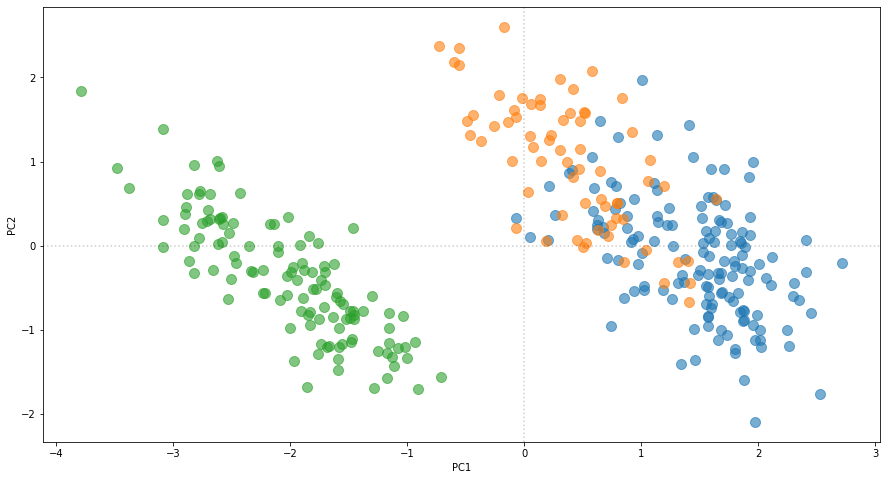

In [103]:
#
unique_labels = np.unique(penguins_labels)

#
plt.figure(figsize=(15, 8))


for i in unique_labels:
  filtered_points = points[penguins_labels == i]
  plt.scatter(filtered_points[:,0], filtered_points[:,1], s=100, alpha=0.6)

plt.axvline(x = 0, color = 'k', linestyle=':', alpha=0.2)
plt.axhline(y = 0, color = 'k', linestyle=':', alpha=0.2)

plt.xlabel("PC1")
_ = plt.ylabel("PC2")


# Referências

- https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index
- https://www.youtube.com/watch?v=Lsue2gEM9D0&list=TLPQMjkwNjIwMjMNHQmVmI7hQQ&index=2&ab_channel=StatQuestwithJoshStarmer
- https://www.youtube.com/watch?v=t012n9Kkh5c&list=TLPQMjkwNjIwMjMNHQmVmI7hQQ&index=3&ab_channel=DrShavetaArora